In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import fashion_mnist

In [2]:
(X_train,_),(X_test,_) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

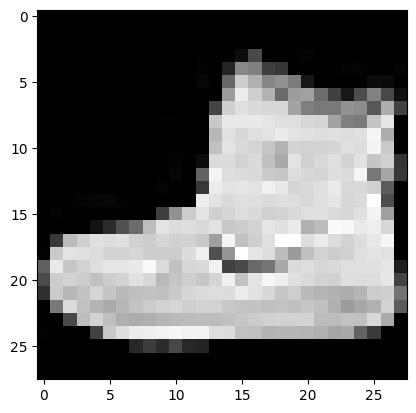

In [5]:
plt.imshow(X_train[0], cmap = 'gray')

In [6]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

In [7]:
latent_dim = 512
image_size = 28

In [8]:
from keras.models import Sequential, Model

from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, BatchNormalization, Lambda, LeakyReLU, Layer, Reshape
from keras.layers import Multiply, Add
from keras.activations import selu

from keras import backend as K

In [9]:
class SamplingLayer(Layer):
    def __init__(self, latent_dim, **kwargs):
        super(SamplingLayer, self).__init__(**kwargs)
        self.latent_dim = latent_dim

    def call(self, inputs):
        mu, log_var = inputs  # inputs: [mu, log_var]

        # === KL divergence loss ===
        kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
        self.add_loss(kl_loss)

        # === Reparameterization trick ===
        batch_size = tf.shape(mu)[0]
        epsilon = tf.random.normal(shape=(batch_size, self.latent_dim))
        sigma = tf.exp(0.5 * log_var)
        z = mu + sigma * epsilon
        return z

In [10]:
encoder_input = Input(shape = (image_size, image_size, 1)) # Change the input shape to (28, 28, 1)

x = Conv2D(32, (5,5), strides = 1, padding = "same")(encoder_input)
x = LeakyReLU(0.02)(x)
x = BatchNormalization()(x)

filter_size = [64, 128]
for i in filter_size:
  x = Conv2D(i, (5,5), strides = 2, padding = "same")(x)
  x = LeakyReLU(0.02)(x)
  x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# Sampling
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

z = SamplingLayer(latent_dim)([mu, log_var])

encoder = Model(encoder_input, [z, mu, log_var])
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 28, 28,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 128) │    204,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 7, 7, 128) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  6,423,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_layer      │ (None, 512)       │          0 │ dense_1[0][0],    │
│ (SamplingLayer)     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,735,168 (29.51 MB)

 Trainable params: 7,732,672 (29.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [11]:
decoder = Sequential()

decoder.add(Dense(1024, activation = selu, input_dim = latent_dim))
decoder.add(BatchNormalization())

decoder.add(Dense(7*7*128, activation = selu))
decoder.add(Reshape((7,7,128)))

decoder.add(Conv2DTranspose(64, (4,4), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (4,4), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

# Change the number of filters to 1 and remove the BatchNormalization layer
decoder.add(Conv2DTranspose(1, (3,3), activation = "sigmoid", strides = 1, padding = "same"))
# decoder.add(BatchNormalization()) # Remove this line

decoder.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6272)           │     6,428,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,122,817 (27.17 MB)

 Trainable params: 7,120,577 (27.16 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [12]:
mu, log_var, z = encoder(encoder_input)

reconstructed = decoder(z)

model = Model(encoder_input, reconstructed)
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ [(None, 512), (None,   │     7,735,168 │
│                                 │ 512), (None, 512)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 28, 28, 1)      │     7,122,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,857,985 (56.68 MB)

 Trainable params: 14,853,249 (56.66 MB)

 Non-trainable params: 4,736 (18.50 KB)

In [13]:
def reconstruction_loss(y, y_pred):
  return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
  loss = -0.5* tf.reduce_mean(log_var - tf.square(mu) - tf.exp(log_var) + 1)
  return loss

def vae_loss(y, y_pred, mu, log_var):
  reconstruction = reconstruction_loss(y, y_pred)
  kl = (1 / 64*64) * kl_loss(mu, log_var)
  return reconstruction + kl

In [14]:
class VAE(Model):
    def __init__(self, encoder, decoder, reconstruction_loss_fn):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.reconstruction_loss_fn = reconstruction_loss_fn

    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstructed = self.decoder(z)
        # Store KL divergence as regularization loss
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.add_loss(kl_loss)
        return reconstructed

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]  # Ignore labels if any

        with tf.GradientTape() as tape:
            reconstructed = self(data, training=True)
            reconstruction_loss = self.reconstruction_loss_fn(tf.reshape(data, [-1]), tf.reshape(reconstructed, [-1]))
            kl_loss = tf.reduce_sum(self.losses)
            total_loss = reconstruction_loss + 0.01 * kl_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "total_loss": total_loss,
        }


In [15]:
vae = VAE(encoder, decoder, reconstruction_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
vae.compile(optimizer=optimizer)

In [16]:
from keras.callbacks import Callback

class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.reconstruction_losses = []
        self.kl_losses = []
        self.total_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.reconstruction_losses.append(logs.get("reconstruction_loss"))
        self.kl_losses.append(logs.get("kl_loss"))
        self.total_losses.append(logs.get("total_loss"))


In [17]:
import time

loss_history = LossHistory()

start_time = time.time()

vae.fit(X_train[:3000], epochs=10, callbacks=[loss_history])

end_time = time.time()
training_duration = end_time - start_time

print(f"Total training time: {training_duration:.2f} seconds")


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - kl_loss: 0.6320 - reconstruction_loss: 0.0702 - total_loss: 0.0765
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - kl_loss: 0.5146 - reconstruction_loss: 0.0304 - total_loss: 0.0356
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 0.4667 - reconstruction_loss: 0.0257 - total_loss: 0.0304
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 0.4472 - reconstruction_loss: 0.0230 - total_loss: 0.0274
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 0.4359 - reconstruction_loss: 0.0208 - total_loss: 0.0251
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - kl_loss: 0.4278 - reconstruction_loss: 0.0191 - total_loss: 0.0234
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - kl_loss: 0.4234 - reconstruction_loss: 0.0178 - total_loss: 0.0221
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - kl_loss: 0.4190 - reconstruction_loss: 0.0169 - total_loss: 0.0211
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 

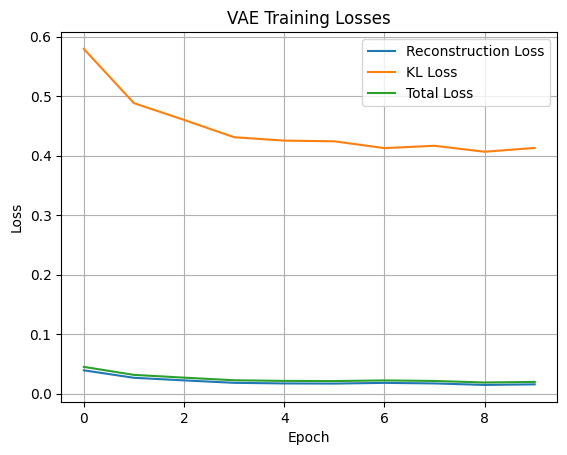

In [18]:
plt.plot(loss_history.reconstruction_losses, label="Reconstruction Loss")
plt.plot(loss_history.kl_losses, label="KL Loss")
plt.plot(loss_history.total_losses, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Losses")
plt.grid(True)
plt.show()

In [19]:
reconstructed = vae.predict(X_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [20]:
def show_reconstructed_images(X_test, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

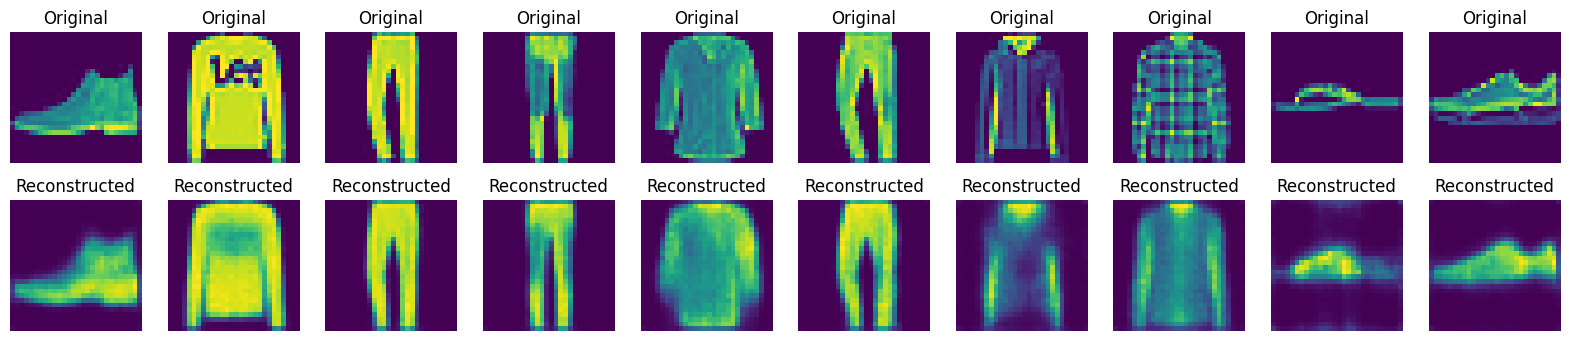

In [21]:
show_reconstructed_images(X_test, reconstructed, n=10)

## VAE with encoder having encoder-decoder arch

In [22]:
encoder_input = Input(shape = (image_size, image_size, 1)) # Change the input shape to (28, 28, 1)

x = Conv2D(32, (5,5), strides = 1, padding = "same")(encoder_input)
x = LeakyReLU(0.02)(x)
x = BatchNormalization()(x)

filter_size = [64, 128]
for i in filter_size:
  x = Conv2D(i, (5,5), strides = 2, padding = "same")(x)
  x = LeakyReLU(0.02)(x)
  x = BatchNormalization()(x)

x = Conv2DTranspose(64, (4,4), strides = 2, padding = "same")(x)
x = LeakyReLU(0.02)(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# Sampling
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

z = SamplingLayer(latent_dim)([mu, log_var])

encoder = Model(encoder_input, [z, mu, log_var])
encoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │        832 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 28, 28,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ leaky_re_lu_5[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 14, 14,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ leaky_re_lu_6[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 128) │    204,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 7, 7, 128) │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ leaky_re_lu_7[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 14, 14,    │    131,136 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 14, 14,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ leaky_re_lu_8[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12544)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1024)      │ 12,846,080 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,289,088 (54.51 MB)

 Trainable params: 14,286,464 (54.50 MB)

 Non-trainable params: 2,624 (10.25 KB)

In [23]:
decoder = Sequential()

decoder.add(Dense(1024, activation = selu, input_dim = latent_dim))
decoder.add(BatchNormalization())

decoder.add(Dense(14*14*64, activation = selu))
decoder.add(Reshape((14,14,64)))

decoder.add(Conv2DTranspose(32, (4,4), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

# Change the number of filters to 1 and remove the BatchNormalization layer
decoder.add(Conv2DTranspose(1, (3,3), activation = "sigmoid", strides = 1, padding = "same"))
# decoder.add(BatchNormalization()) # Remove this line

decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12544)          │    12,857,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,420,225 (51.19 MB)

 Trainable params: 13,418,113 (51.19 MB)

 Non-trainable params: 2,112 (8.25 KB)

In [24]:
mu, log_var, z = encoder(encoder_input)

reconstructed = decoder(z)

model2 = Model(encoder_input, reconstructed)
model2.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_13 (Functional)      │ [(None, 512), (None,   │    14,289,088 │
│                                 │ 512), (None, 512)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 1)      │    13,420,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,709,313 (105.70 MB)

 Trainable params: 27,704,577 (105.68 MB)

 Non-trainable params: 4,736 (18.50 KB)

In [25]:
vae2 = VAE(encoder, decoder, reconstruction_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
vae2.compile(optimizer=optimizer)

In [26]:
loss_history2 = LossHistory()

start_time = time.time()

vae2.fit(X_train[:3000], epochs=10, callbacks=[loss_history2])

end_time = time.time()
training_duration2 = end_time - start_time

print(f"Total training time: {training_duration2:.2f} seconds")

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - kl_loss: 0.6207 - reconstruction_loss: 0.0692 - total_loss: 0.0754
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - kl_loss: 0.5204 - reconstruction_loss: 0.0312 - total_loss: 0.0364
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - kl_loss: 0.4688 - reconstruction_loss: 0.0262 - total_loss: 0.0309
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - kl_loss: 0.4444 - reconstruction_loss: 0.0235 - total_loss: 0.0280
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - kl_loss: 0.4337 - reconstruction_loss: 0.0214 - total_loss: 0.0257
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - kl_loss: 0.4266 - reconstruction_loss: 0.0197 - total_loss: 0.0239
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - kl_loss: 0.4231 - reconstruction_loss: 0.0182 - total_loss: 0.0225
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - kl_loss: 0.4192 - reconstruction_loss: 0.0171 - total_loss: 0.0213
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1

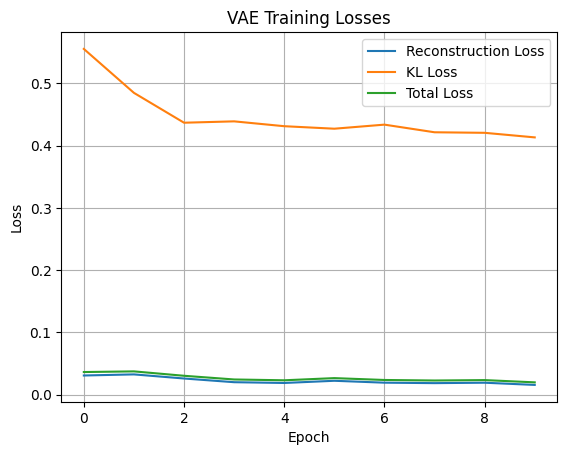

In [27]:
plt.plot(loss_history2.reconstruction_losses, label="Reconstruction Loss")
plt.plot(loss_history2.kl_losses, label="KL Loss")
plt.plot(loss_history2.total_losses, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Losses")
plt.grid(True)
plt.show()

In [28]:
reconstructed2 = vae2.predict(X_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


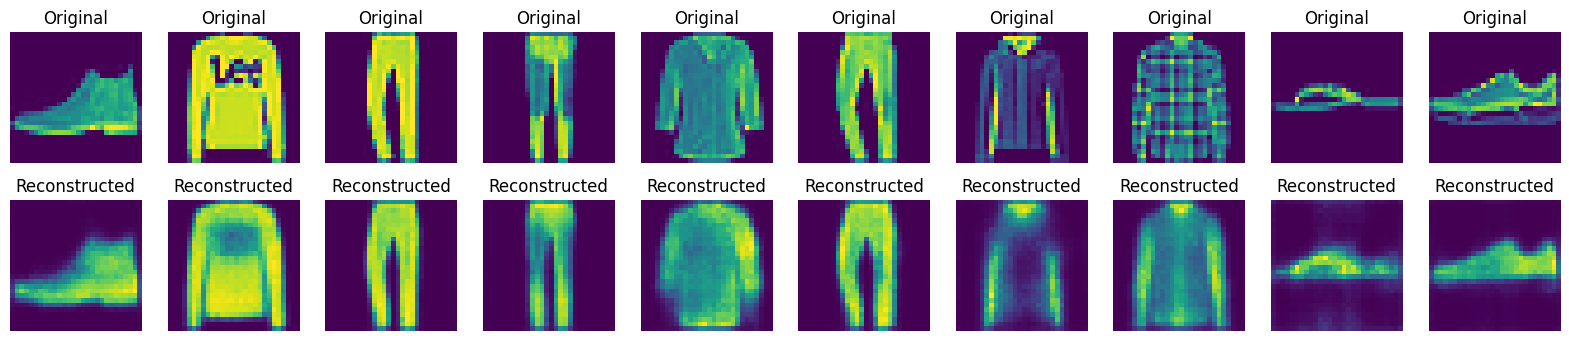

In [29]:
show_reconstructed_images(X_test, reconstructed2, n=10)

## VAE with decoder having encoder-decoder arch

In [30]:
encoder_input = Input(shape = (image_size, image_size, 1)) # Change the input shape to (28, 28, 1)

x = Conv2D(32, (5,5), strides = 1, padding = "same")(encoder_input)
x = LeakyReLU(0.02)(x)
x = BatchNormalization()(x)

filter_size = [64, 128]
for i in filter_size:
  x = Conv2D(i, (5,5), strides = 2, padding = "same")(x)
  x = LeakyReLU(0.02)(x)
  x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# Sampling
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

z = SamplingLayer(latent_dim)([mu, log_var])

encoder = Model(encoder_input, [z, mu, log_var])
encoder.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │        832 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 28, 28,    │          0 │ conv2d_6[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ leaky_re_lu_10[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ leaky_re_lu_11[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 7, 7, 128) │    204,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 7, 7, 128) │          0 │ conv2d_8[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ leaky_re_lu_12[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 6272)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1024)      │  6,423,552 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_layer_2    │ (None, 512)       │          0 │ dense_11[0][0],   │
│ (SamplingLayer)     │                   │            │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,735,168 (29.51 MB)

 Trainable params: 7,732,672 (29.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [31]:
decoder = Sequential()

decoder.add(Dense(1024, activation = selu, input_dim = latent_dim))
decoder.add(BatchNormalization())

decoder.add(Dense(14*14*64, activation = selu))
decoder.add(Reshape((14,14,64)))

decoder.add(Conv2D(128, (5,5), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (4,4), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (4,4), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

# Change the number of filters to 1 and remove the BatchNormalization layer
decoder.add(Conv2DTranspose(1, (3,3), activation = "sigmoid", strides = 1, padding = "same"))
# decoder.add(BatchNormalization()) # Remove this line

decoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 12544)          │    12,857,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,757,057 (52.48 MB)

 Trainable params: 13,754,561 (52.47 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [32]:
mu, log_var, z = encoder(encoder_input)

reconstructed = decoder(z)

model3 = Model(encoder_input, reconstructed)
model3.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_23 (Functional)      │ [(None, 512), (None,   │     7,735,168 │
│                                 │ 512), (None, 512)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 1)      │    13,757,057 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,492,225 (81.99 MB)

 Trainable params: 21,487,233 (81.97 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [33]:
vae3 = VAE(encoder, decoder, reconstruction_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
vae3.compile(optimizer=optimizer)

In [34]:
loss_history3 = LossHistory()

start_time = time.time()

vae3.fit(X_train[:3000], epochs=10, callbacks=[loss_history3])

end_time = time.time()
training_duration3 = end_time - start_time

print(f"Total training time: {training_duration3:.2f} seconds")

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - kl_loss: 0.5903 - reconstruction_loss: 0.0731 - total_loss: 0.0790
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - kl_loss: 0.4871 - reconstruction_loss: 0.0318 - total_loss: 0.0367
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - kl_loss: 0.4521 - reconstruction_loss: 0.0276 - total_loss: 0.0321
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - kl_loss: 0.4343 - reconstruction_loss: 0.0247 - total_loss: 0.0290
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - kl_loss: 0.4266 - reconstruction_loss: 0.0226 - total_loss: 0.0268
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - kl_loss: 0.4210 - reconstruction_loss: 0.0212 - total_loss: 0.0254
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - kl_loss: 0.4164 - reconstruction_loss: 0.0195 - total_loss: 0.0237
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - kl_loss: 0.4135 - reconstruction_loss: 0.0183 - total_loss: 0.0224
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1

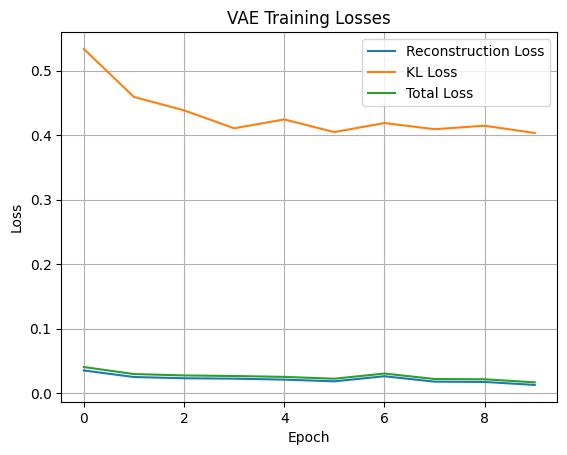

In [35]:
plt.plot(loss_history3.reconstruction_losses, label="Reconstruction Loss")
plt.plot(loss_history3.kl_losses, label="KL Loss")
plt.plot(loss_history3.total_losses, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Losses")
plt.grid(True)
plt.show()

In [36]:
reconstructed3 = vae3.predict(X_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


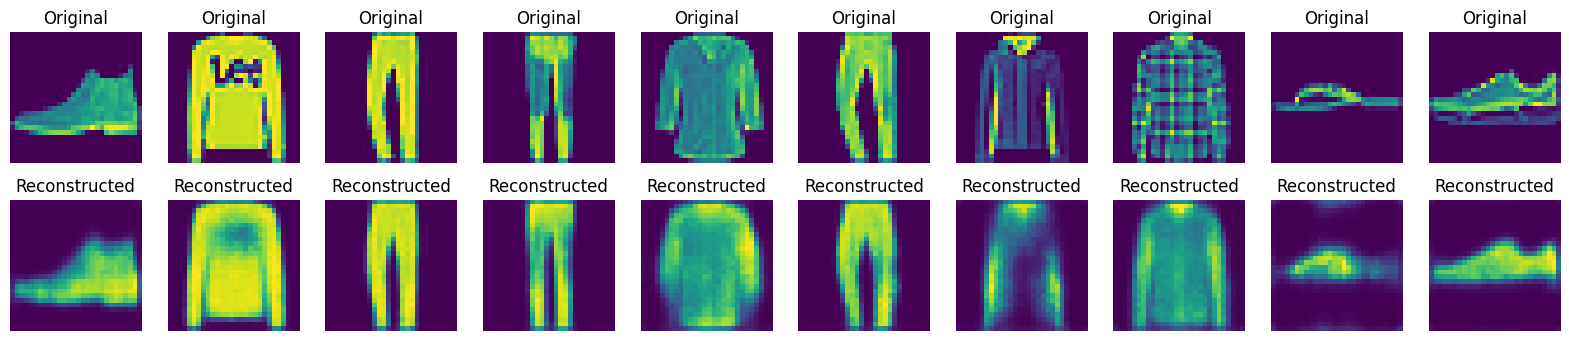

In [37]:
show_reconstructed_images(X_test, reconstructed3, n=10)

## VAE with both encoder and decoder having encoder-decoder arch

In [38]:
encoder_input = Input(shape = (image_size, image_size, 1)) # Change the input shape to (28, 28, 1)

x = Conv2D(32, (5,5), strides = 1, padding = "same")(encoder_input)
x = LeakyReLU(0.02)(x)
x = BatchNormalization()(x)

filter_size = [64, 128]
for i in filter_size:
  x = Conv2D(i, (5,5), strides = 2, padding = "same")(x)
  x = LeakyReLU(0.02)(x)
  x = BatchNormalization()(x)

x = Conv2DTranspose(64, (4,4), strides = 2, padding = "same")(x)
x = LeakyReLU(0.02)(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# Sampling
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

z = SamplingLayer(latent_dim)([mu, log_var])

encoder = Model(encoder_input, [z, mu, log_var])
encoder.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │        832 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 28, 28,    │          0 │ conv2d_10[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ leaky_re_lu_16[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 14, 14,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 14, 14,    │          0 │ conv2d_11[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ leaky_re_lu_17[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 7, 7, 128) │    204,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 7, 7, 128) │          0 │ conv2d_12[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ leaky_re_lu_18[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 14, 14,    │    131,136 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 14, 14,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ leaky_re_lu_19[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12544)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1024)      │ 12,846,080 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,289,088 (54.51 MB)

 Trainable params: 14,286,464 (54.50 MB)

 Non-trainable params: 2,624 (10.25 KB)

In [39]:
decoder = Sequential()

decoder.add(Dense(1024, activation = selu, input_dim = latent_dim))
decoder.add(BatchNormalization())

decoder.add(Dense(14*14*64, activation = selu))
decoder.add(Reshape((14,14,64)))

decoder.add(Conv2D(128, (5,5), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (4,4), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (4,4), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

# Change the number of filters to 1 and remove the BatchNormalization layer
decoder.add(Conv2DTranspose(1, (3,3), activation = "sigmoid", strides = 1, padding = "same"))
# decoder.add(BatchNormalization()) # Remove this line

decoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 12544)          │    12,857,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 14, 14, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 28, 28, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,757,057 (52.48 MB)

 Trainable params: 13,754,561 (52.47 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [40]:
mu, log_var, z = encoder(encoder_input)

reconstructed = decoder(z)

model4 = Model(encoder_input, reconstructed)
model4.summary()

Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_39 (Functional)      │ [(None, 512), (None,   │    14,289,088 │
│                                 │ 512), (None, 512)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 28, 28, 1)      │    13,757,057 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,046,145 (106.99 MB)

 Trainable params: 28,041,025 (106.97 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [41]:
vae4 = VAE(encoder, decoder, reconstruction_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
vae4.compile(optimizer=optimizer)

In [42]:
loss_history4 = LossHistory()

start_time = time.time()

vae4.fit(X_train[:3000], epochs=10, callbacks=[loss_history4])

end_time = time.time()
training_duration4 = end_time - start_time

print(f"Total training time: {training_duration4:.2f} seconds")

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - kl_loss: 0.5645 - reconstruction_loss: 0.0763 - total_loss: 0.0819
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - kl_loss: 0.4820 - reconstruction_loss: 0.0329 - total_loss: 0.0377
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - kl_loss: 0.4490 - reconstruction_loss: 0.0284 - total_loss: 0.0329
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - kl_loss: 0.4341 - reconstruction_loss: 0.0250 - total_loss: 0.0293
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - kl_loss: 0.4246 - reconstruction_loss: 0.0232 - total_loss: 0.0274
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - kl_loss: 0.4196 - reconstruction_loss: 0.0215 - total_loss: 0.0257
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - kl_loss: 0.4156 - reconstruction_loss: 0.0200 - total_loss: 0.0241
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - kl_loss: 0.4124 - reconstruction_loss: 0.0186 - total_loss: 0.0228
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1

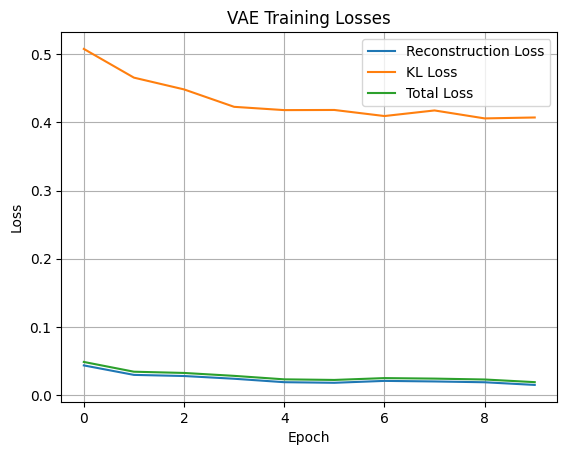

In [43]:
plt.plot(loss_history4.reconstruction_losses, label="Reconstruction Loss")
plt.plot(loss_history4.kl_losses, label="KL Loss")
plt.plot(loss_history4.total_losses, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Losses")
plt.grid(True)
plt.show()

In [44]:
reconstructed4 = vae4.predict(X_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


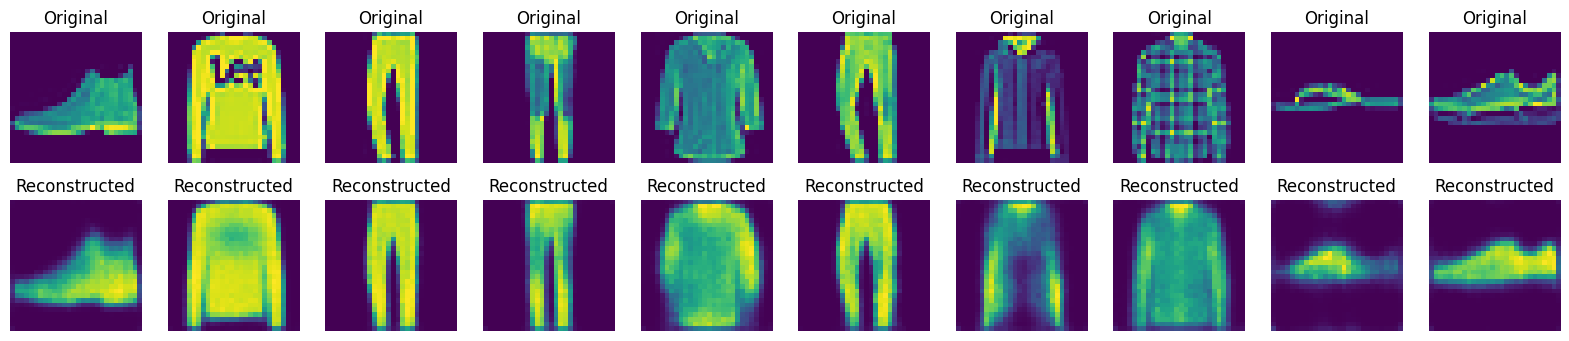

In [45]:
show_reconstructed_images(X_test, reconstructed4, n=10)